### Evaluation of the different latent spaces obtained with the different models.
- PCA
- KPCA
- AE
- DAE

In [18]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

X_train_norm, X_train_swapped, X_test_norm, y_train, y_test, y_train_oh, y_test_oh = Models.prepare_datasets(X_renal_data.iloc[:,1:],y_renal_data["label"], test_size=0.2)

# X_train_norm is the training dataset, normalized, that we will use to fit PCA, KPCA and the AE. 
# X_train_swapped is the same dataset with "swap noise", that we will use to fit the DAE.

swapping: 65 rows.


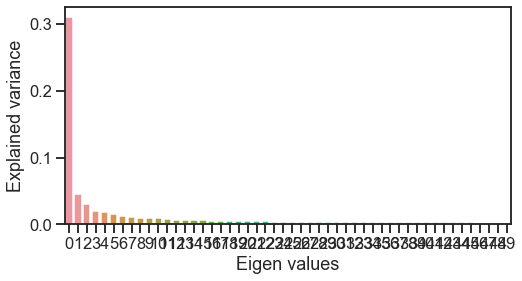

PCA on single-modal explained variance ratio: 0.6460561619179183


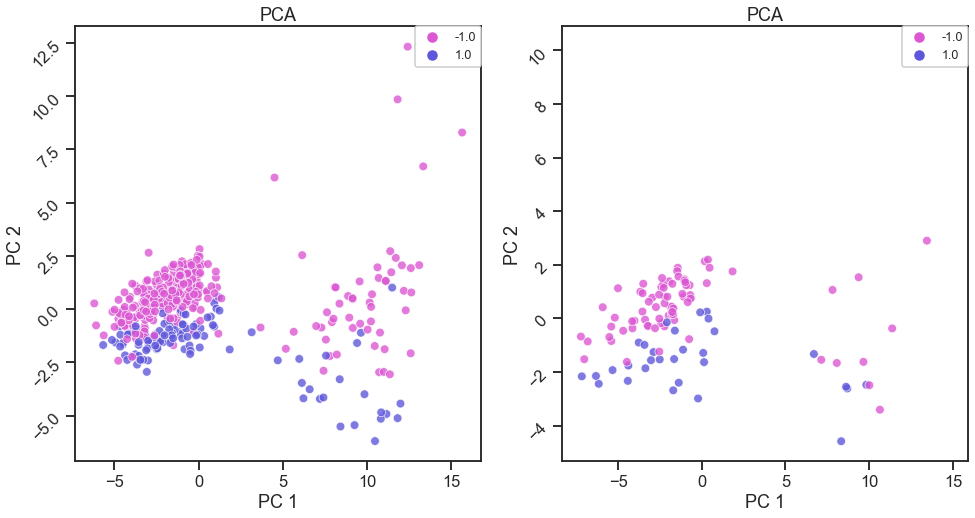

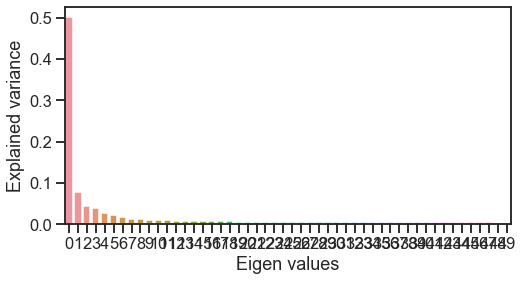

0.7128692970423495


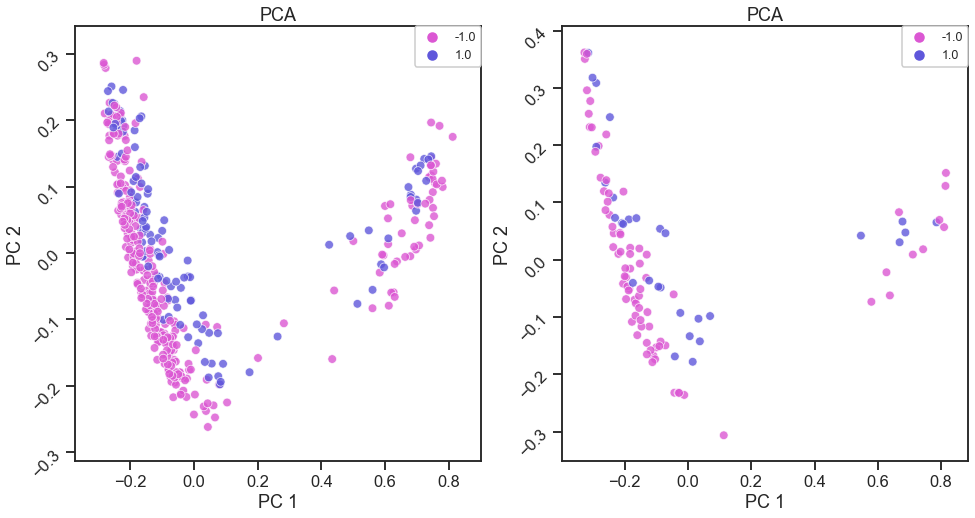

Compression: 102.52
Train on 433 samples
Epoch 1/90
433/433 [==============================] - 2s 4ms/sample - loss: 1.0456 - mse: 0.1815
Epoch 2/90
433/433 [==============================] - 0s 763us/sample - loss: 0.5074 - mse: 0.1781
Epoch 3/90
433/433 [==============================] - 0s 762us/sample - loss: 0.3204 - mse: 0.1736
Epoch 4/90
433/433 [==============================] - 0s 767us/sample - loss: 0.2718 - mse: 0.1667
Epoch 5/90
433/433 [==============================] - 0s 762us/sample - loss: 0.2502 - mse: 0.1565
Epoch 6/90
433/433 [==============================] - 0s 841us/sample - loss: 0.2425 - mse: 0.1429
Epoch 7/90
433/433 [==============================] - 0s 861us/sample - loss: 0.2344 - mse: 0.1259
Epoch 8/90
433/433 [==============================] - 0s 799us/sample - loss: 0.2266 - mse: 0.1065
Epoch 9/90
433/433 [==============================] - 0s 905us/sample - loss: 0.2076 - mse: 0.0879
Epoch 10/90
433/433 [==============================] - 0s 837us/sample

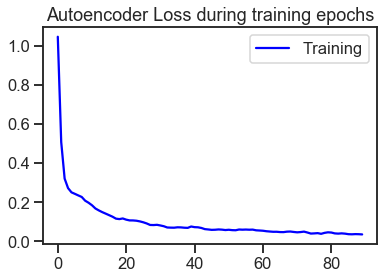

0.03514565174698004
Compression: 102.52
Train on 433 samples
Epoch 1/90
433/433 [==============================] - 2s 4ms/sample - loss: 1.0449 - mse: 0.1815
Epoch 2/90
433/433 [==============================] - 0s 766us/sample - loss: 0.5079 - mse: 0.1782
Epoch 3/90
433/433 [==============================] - 0s 749us/sample - loss: 0.3207 - mse: 0.1738
Epoch 4/90
433/433 [==============================] - 0s 744us/sample - loss: 0.2704 - mse: 0.1672
Epoch 5/90
433/433 [==============================] - 0s 744us/sample - loss: 0.2514 - mse: 0.1570
Epoch 6/90
433/433 [==============================] - 0s 772us/sample - loss: 0.2393 - mse: 0.1431
Epoch 7/90
433/433 [==============================] - 0s 753us/sample - loss: 0.2261 - mse: 0.1260
Epoch 8/90
433/433 [==============================] - 0s 762us/sample - loss: 0.2288 - mse: 0.1080
Epoch 9/90
433/433 [==============================] - 0s 735us/sample - loss: 0.2114 - mse: 0.0906
Epoch 10/90
433/433 [=============================

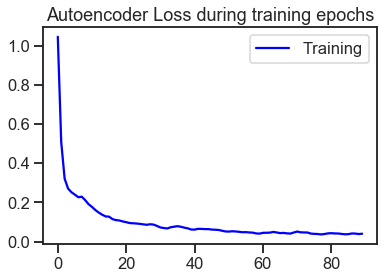

0.039857272824431675


In [21]:
## Perform PCA
X_latent_pca, X_latent_test_pca = Models.perform_PCA(X_train_norm, X_test_norm, y_train, y_test, n_components=50)
## Perform KPCA
X_latent_kpca, X_latent_test_kpca = Models.perform_KPCA(X_train_norm, X_test_norm, y_train, y_test, n_components=50, kernel="rbf", gamma=0.008)
## Build and Train Autoencoder
autoencoder, encoder, decoder = Models.build_and_train_autoencoder(X_train_norm,
                                                                  X_train_norm,
                                                                  encoding_dim=50, 
                                                                  regularizer=tf.keras.regularizers.l1_l2(0.0001,0),
                                                                  dropout=0.5,
                                                                  epochs=90)

X_latent_ae = Models.encode_dataset(X_train_norm, encoder)
X_latent_test_ae = Models.encode_dataset(X_test_norm, encoder)
## Build and Train Denoising Autoencoder
d_autoencoder, d_encoder, d_decoder = Models.build_and_train_autoencoder(X_train_swapped,
                                                                         X_train_norm, 
                                                                         encoding_dim=50, 
                                                                         regularizer=tf.keras.regularizers.l1_l2(0.0001,0),
                                                                         dropout=0.5,
                                                                         epochs=90)
X_latent_dae = Models.encode_dataset(X_train_norm, d_encoder)
X_latent_test_dae = Models.encode_dataset(X_test_norm, d_encoder)

# Latent Representations:
# - PCA: X_latent_pca, X_latent_test_pca
# - KPCA: X_latent_kpca, X_latent_test_kpca
# - AE: X_latent_ae, X_latent_test_ae
# - DAE: X_latent_dae, X_latent_test_dae

In [30]:
import importlib
importlib.reload(Models)
print(X_latent_pca.shape)
print(X_latent_kpca.shape)
print(X_latent_ae.shape)
print(X_latent_dae.shape)

(433, 50)
(433, 50)
(433, 50)
(433, 50)


In [22]:
### CLASSIFICATION ###
# We use the reduced datasets to train a classifier and compare them.
# PCA Classification
Models.classify(X_latent_pca, X_latent_test_pca, y_train, y_test, model_type="PCA")
# KPCA Classification
Models.classify(X_latent_kpca, X_latent_test_kpca, y_train, y_test, model_type="KPCA")
# AE Classification
Models.classify(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")
# DAE Classification
Models.classify(X_latent_dae, X_latent_test_dae, y_train, y_test, model_type="DAE")



Results for PCA: 

[[76  3]
 [ 1 29]]


              precision    recall  f1-score   support

          -1       0.99      0.96      0.97        79
           1       0.91      0.97      0.94        30

    accuracy                           0.96       109
   macro avg       0.95      0.96      0.95       109
weighted avg       0.96      0.96      0.96       109

Training set score for Logistic Regression: 0.986143
Testing  set score for Logistic Regression: 0.963303
[[77  2]
 [18 12]]


              precision    recall  f1-score   support

          -1       0.81      0.97      0.89        79
           1       0.86      0.40      0.55        30

    accuracy                           0.82       109
   macro avg       0.83      0.69      0.72       109
weighted avg       0.82      0.82      0.79       109

Training set score for SVM: 0.877598
Testing  set score for SVM: 0.816514
[[77  2]
 [ 4 26]]


              precision    recall  f1-score   support

          -1       0.95      

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[77  2]
 [ 6 24]]


              precision    recall  f1-score   support

          -1       0.93      0.97      0.95        79
           1       0.92      0.80      0.86        30

    accuracy                           0.93       109
   macro avg       0.93      0.89      0.90       109
weighted avg       0.93      0.93      0.92       109

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.926606
Results for AE: 

[[79  0]
 [30  0]]


              precision    recall  f1-score   support

          -1       0.72      1.00      0.84        79
           1       0.00      0.00      0.00        30

    accuracy                           0.72       109
   macro avg       0.36      0.50      0.42       109
weighted avg       0.53      0.72      0.61       109

Training set score for Logistic Regression: 0.734411
Testing  set score for Logistic Regression: 0.724771
[[79  0]
 [30  0]]


              precision    recall  f1-score   support

          -1       0.72      1

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[53 26]
 [ 7 23]]


              precision    recall  f1-score   support

          -1       0.88      0.67      0.76        79
           1       0.47      0.77      0.58        30

    accuracy                           0.70       109
   macro avg       0.68      0.72      0.67       109
weighted avg       0.77      0.70      0.71       109

Training set score for RFC: 0.997691
Testing  set score for RFC: 0.697248
Results for DAE: 

[[79  0]
 [30  0]]


              precision    recall  f1-score   support

          -1       0.72      1.00      0.84        79
           1       0.00      0.00      0.00        30

    accuracy                           0.72       109
   macro avg       0.36      0.50      0.42       109
weighted avg       0.53      0.72      0.61       109

Training set score for Logistic Regression: 0.734411
Testing  set score for Logistic Regression: 0.724771
[[79  0]
 [30  0]]


              precision    recall  f1-score   support

          -1       0.72      

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[75  4]
 [25  5]]


              precision    recall  f1-score   support

          -1       0.75      0.95      0.84        79
           1       0.56      0.17      0.26        30

    accuracy                           0.73       109
   macro avg       0.65      0.56      0.55       109
weighted avg       0.70      0.73      0.68       109

Training set score for RFC: 0.997691
Testing  set score for RFC: 0.733945


PCA 2 clusters silhoutte score: 0.5621789737597149
PCA 3 clusters silhoutte score: 0.16360553131660616
PCA 4 clusters silhoutte score: 0.15780298815349578
PCA 5 clusters silhoutte score: 0.15975621592787603
PCA 6 clusters silhoutte score: 0.16160283847166446
PCA 7 clusters silhoutte score: 0.1325168910480252
PCA 8 clusters silhoutte score: 0.13492566957227617
PCA 9 clusters silhoutte score: 0.1237277035979034


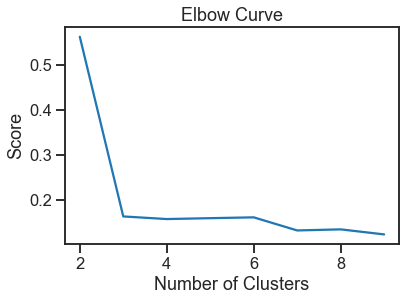

KPCA 2 clusters silhoutte score: 0.5614042417788889
KPCA 3 clusters silhoutte score: 0.20470570916255107
KPCA 4 clusters silhoutte score: 0.18532098502056282
KPCA 5 clusters silhoutte score: 0.18418049072373696
KPCA 6 clusters silhoutte score: 0.1789899815089444
KPCA 7 clusters silhoutte score: 0.12238685144208529
KPCA 8 clusters silhoutte score: 0.11978848673371799
KPCA 9 clusters silhoutte score: 0.11187705789993119


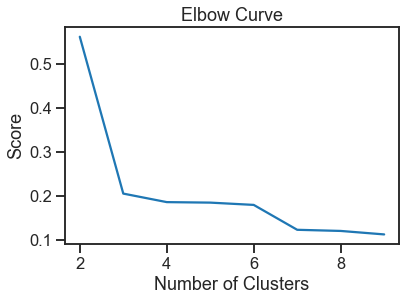

AE 2 clusters silhoutte score: 0.8433571457862854
AE 3 clusters silhoutte score: 0.8032627701759338
AE 4 clusters silhoutte score: 0.7991763353347778
AE 5 clusters silhoutte score: 0.5063230395317078
AE 6 clusters silhoutte score: 0.49998265504837036
AE 7 clusters silhoutte score: 0.4989713430404663
AE 8 clusters silhoutte score: 0.5044494271278381
AE 9 clusters silhoutte score: 0.509256899356842


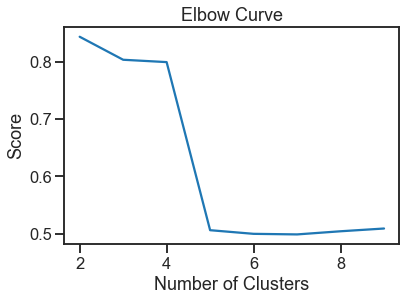

DAE 2 clusters silhoutte score: 0.753628134727478
DAE 3 clusters silhoutte score: 0.7264146208763123
DAE 4 clusters silhoutte score: 0.6768041849136353
DAE 5 clusters silhoutte score: 0.6682067513465881
DAE 6 clusters silhoutte score: 0.6651113629341125
DAE 7 clusters silhoutte score: 0.6692895889282227
DAE 8 clusters silhoutte score: 0.6714314818382263
DAE 9 clusters silhoutte score: 0.6702507138252258


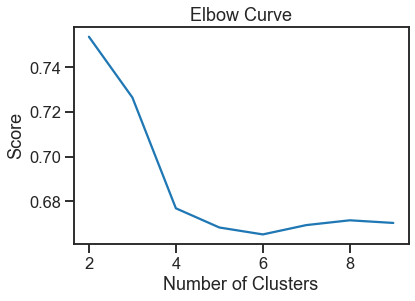

In [31]:
###### CLUSTERING ###
# PCA Clustering
Models.cluster(X_latent_pca, model_type="PCA")
# KPCA Clustering
Models.cluster(X_latent_kpca, model_type="KPCA")
# AE Clustering
Models.cluster(X_latent_ae, model_type="AE")
# DAE Clustering
Models.cluster(X_latent_dae, model_type="DAE")
